In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bidhyabhattarai123","key":"71894484acb0b80adaaafd37e56357c8"}'}

In [2]:
import os
import zipfile

# Make Kaggle folder and move file
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
100% 218M/218M [00:00<00:00, 662MB/s] 
100% 218M/218M [00:00<00:00, 706MB/s]


In [4]:
with zipfile.ZipFile("cat-and-dog.zip", 'r') as zip_ref:
    zip_ref.extractall("cat_dog_data")

# Check what’s inside
!ls cat_dog_data

test_set  training_set


In [5]:
import os

# List some files inside the extracted folder
print(os.listdir("cat_dog_data")[:10])  # show first 10 files


['test_set', 'training_set']


In [6]:
import os
import shutil

os.makedirs("data/train/cat", exist_ok=True)
os.makedirs("data/train/dog", exist_ok=True)

for filename in os.listdir("data/train"):
    if filename.startswith("cat"):
        shutil.move(f"data/train/{filename}", "data/train/cat")
    elif filename.startswith("dog"):
        shutil.move(f"data/train/{filename}", "data/train/dog")


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [8]:
base_dir = 'cat_dog_data'
train_dir = os.path.join(base_dir, 'training_set')
test_dir = os.path.join(base_dir, 'test_set')

In [9]:
# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Test data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'  # cats vs dogs is binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 8005 images belonging to 1 classes.
Found 2023 images belonging to 1 classes.


In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary output
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Batches per epoch
    epochs=3,  # Train for 10 passes through the dataset
    validation_data=test_generator,
    validation_steps=len(test_generator)
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
251/251 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.9826 - loss: 0.0176 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/3
251/251 ━━━━━━━━━━━━━━━━━━━━ 499s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/3
251/251 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - accuracy: 1.0000 - loss: 1.6941e-37 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


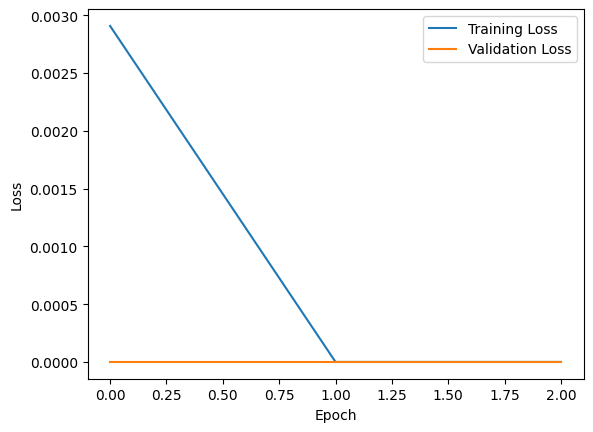

In [13]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

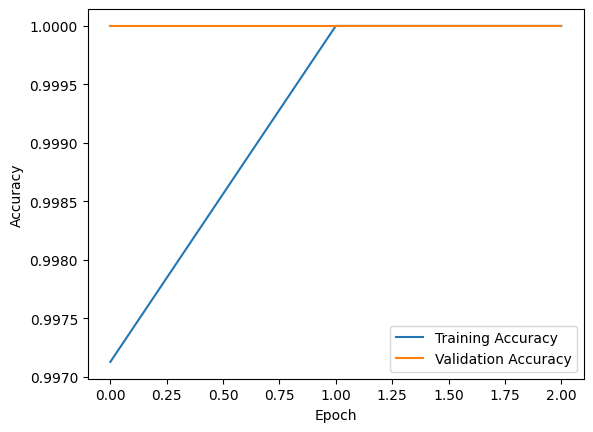

In [14]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
from google.colab import files
uploaded = files.upload()


Saving cat.jpg to cat.jpg


In [35]:
# Step 2: Import required libraries
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


In [36]:
# Step 3: Preprocess the image
# Replace 'your_image.jpg' with the actual uploaded filename
img_path = list(uploaded.keys())[0]  # Automatically get uploaded filename

# Load image and resize it to the size your model expects
img = image.load_img(img_path, target_size=(150, 150))

# Convert to array
img_array = image.img_to_array(img)

# Normalize (model expects values between 0 and 1)
img_array_normalized = img_array / 255.0

# Add batch dimension (model expects shape: (1, 150, 150, 3))
img_array_expanded = np.expand_dims(img_array_normalized, axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


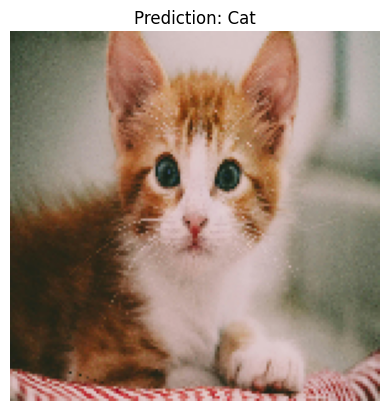

Prediction Score: 0.0000 — Classified as: Cat


In [37]:
# Step 4: Predict using your trained model
prediction = model.predict(img_array_expanded)

# Step 5: Display the image with predicted label
label = "Dog" if prediction[0][0] > 0.5 else "Cat"

plt.imshow(img_array_normalized)
plt.axis('off')
plt.title(f"Prediction: {label}")
plt.show()

# Step 6: Show confidence score
print(f"Prediction Score: {prediction[0][0]:.4f} — Classified as: {label}")
